# Evaluate Fine-tuning Results
This notebook provides evaluation of generated SMIELS in the fine-tuning stage.
  
To switch between **filtered** and **unfiltered** fine-tuning results, modify the variable `FINETUNE_FILTER` in `src/paths.py`.

In [1]:
import sys
sys.path.append('../')

from src.paths import ensure_dirs, FINETUNE_DATA, FINETUNE_RESULTS, FINETUNE_OUT, FINETUNE_FILTER, FIGURES_DIR
ensure_dirs()

dataset_list = ['pubchem_filtered_ac', 
                'pubchem_unfiltered_ac', 
                'pubchem_inac', 
                'chembl_filtered', 
                'chembl_unfiltered', 
                'zinc']

f_data_list = ['CHEMBL4005', 'CHEMBL1908389', 'CHEMBL284', 'CHEMBL214', 'CHEMBL253']
print(f'Fine-tuning data status: {FINETUNE_FILTER}')

Fine-tuning data status: filtered


## 1. Evaluation of Fine-tuning

### 1-1. Validity, Uniqueness and Novelty
- **Validity**: fraction of chemically valid SMILES
- **Uniqueness**: fraction of unique valid SMILES
- **Novelty**: fraction of unique valid SMILES not present in the training set

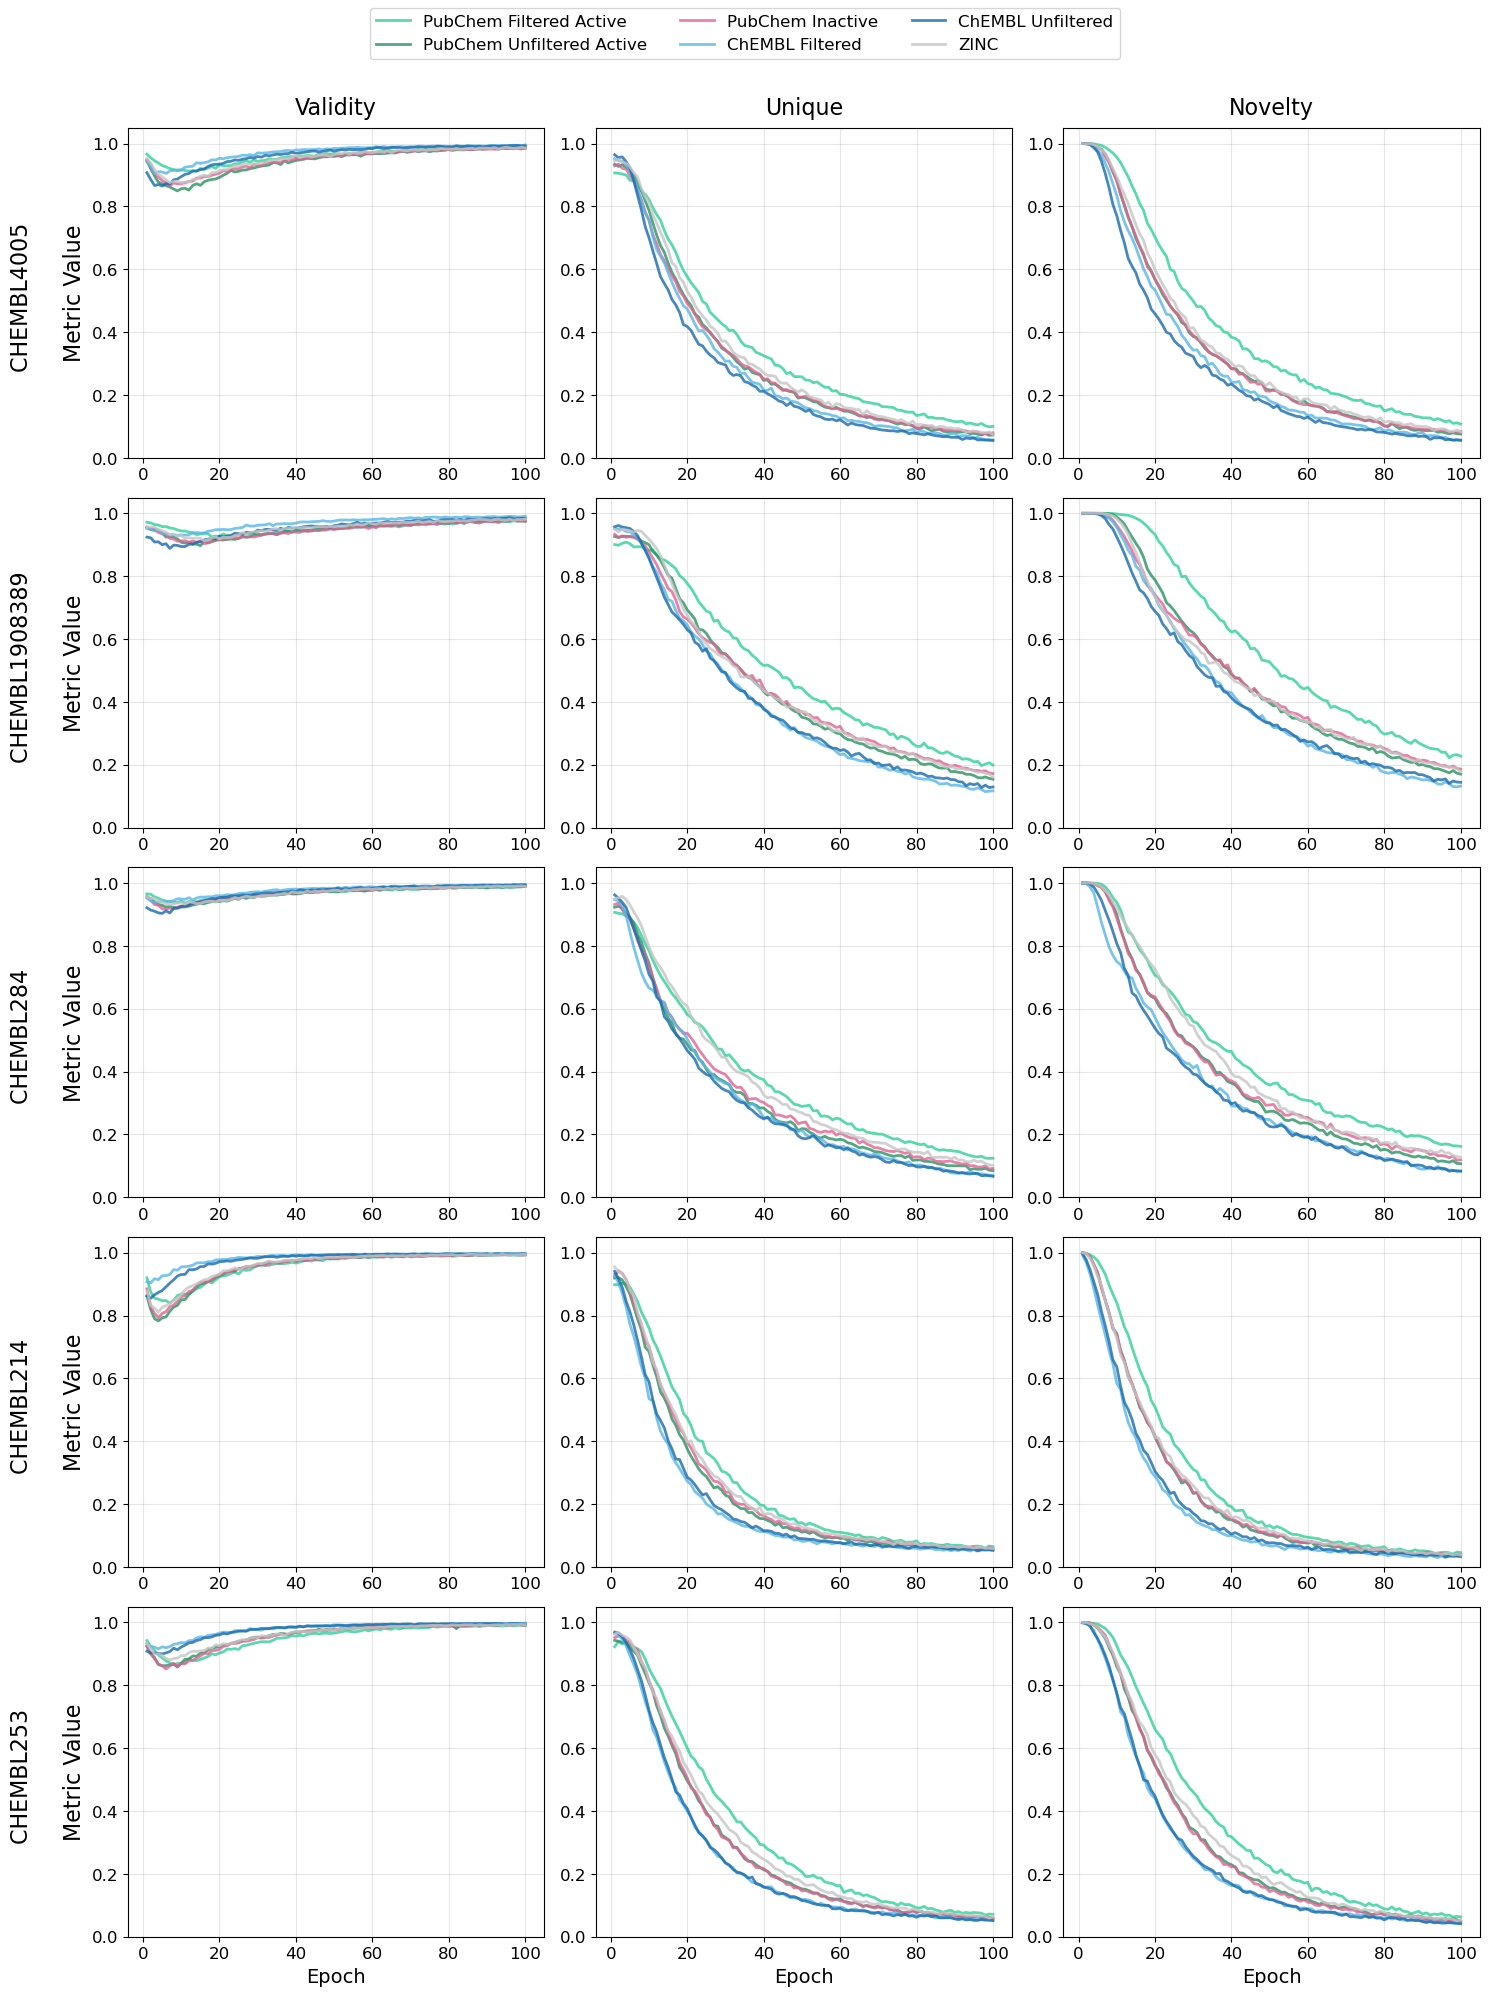

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

pretrain_labels = ['PubChem Filtered Active', 'PubChem Unfiltered Active', 'PubChem Inactive', 'ChEMBL Filtered', 'ChEMBL Unfiltered', 'ZINC']
dataset_colors  = ["#2ED19A", "#279260", "#E36191", "#58B6E6", "#186BAE", "#C6C5C5"]
metrics_cols = ['validity', 'unique', 'novelty']
titles       = ['Validity', 'Unique', 'Novelty']
width = 2

fig, axs = plt.subplots(5, 3, figsize=(15, 20))
for row, f_data in enumerate(f_data_list):
    for col, (metric, label) in enumerate(zip(metrics_cols, titles)):
        ax = axs[row, col]

        for idx, dataset in enumerate(dataset_list):
            metrics_df = pd.read_table(f'{FINETUNE_RESULTS}/{dataset}_results/{f_data}_finetune/finetuning_metrics.tsv', index_col=0)
            metrics_df = metrics_df.iloc[1:]  # Skip the first row (epoch 0)
            ax.plot(metrics_df.index, metrics_df[metric], label=pretrain_labels[idx], color=dataset_colors[idx], alpha=0.8, linewidth=width)

        ax.set_ylim(0, 1.05)
        ax.tick_params(labelsize=12)
        ax.grid(True, alpha=0.3)

        if row == 0:
            ax.set_title(label, fontsize=16, pad=10)
        if row == 4:
            ax.set_xlabel('Epoch', fontsize=14)
        if col == 0:
            ax.set_ylabel(f'{f_data} \n \nMetric Value', fontsize=16)

handles, labels = axs[0, 0].get_legend_handles_labels()

for handle in handles:
    handle.set_linewidth(width)

fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
save_dir = f'{FIGURES_DIR}/finetune/{FINETUNE_FILTER}/'
os.makedirs(save_dir, exist_ok=True)
plt.savefig(f'{save_dir}/finetune_metrics_transition.png', dpi=300)

### 1-2. mean Nearst-Neighbor Tanimoto Similarity


In [ ]:
import os
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from tqdm import tqdm
from src.chem_utils import smiles_to_mols, read_smiles_list_tsv, mols_to_morgan_fps
from src.metrics import mean_NN_gen_to_ref

epochs = list(range(1,101))
save_dir = f'{FINETUNE_OUT}/mean_nn_Tanimoto_Simi/'
os.makedirs(save_dir, exist_ok=True)

for f_data in f_data_list:
    print(f'\n=== {f_data} ===')
    test_path  = f'{FINETUNE_DATA}/{FINETUNE_FILTER}-{f_data}_test.tsv' 
    train_path = f'{FINETUNE_DATA}/{FINETUNE_FILTER}-{f_data}_train.tsv'

    test_smiles  = read_smiles_list_tsv(test_path, col='rdkit_smiles')
    train_smiles = read_smiles_list_tsv(train_path, col='rdkit_smiles')

    test_mols  = smiles_to_mols(test_smiles)
    train_mols = smiles_to_mols(train_smiles)

    test_fps  = mols_to_morgan_fps(test_mols)
    train_fps = mols_to_morgan_fps(train_mols)

    test_gen_simi_by_dataset  = []
    train_gen_simi_by_dataset = []

    for dataset in tqdm(dataset_list):
        test_gen_simi_list  = []
        train_gen_simi_list = []

        for epoch in epochs:
            gen_path = f'{FINETUNE_RESULTS}/{dataset}_results/{f_data}_finetune/sampling/epoch{epoch}_10000samples.tsv'
            gen_smiles = read_smiles_list_tsv(gen_path, col='canonical_smiles', dropna=True, dedup=True)
            gen_mols = smiles_to_mols(gen_smiles)
            gen_fps  = mols_to_morgan_fps(gen_mols)

            mean_nn_test  = mean_NN_gen_to_ref(gen_fps, test_fps)
            mean_nn_train = mean_NN_gen_to_ref(gen_fps, train_fps)

            test_gen_simi_list.append(mean_nn_test)
            train_gen_simi_list.append(mean_nn_train)

        test_gen_simi_by_dataset.append(test_gen_simi_list)
        train_gen_simi_by_dataset.append(train_gen_simi_list)

    simi_test  = pd.DataFrame(test_gen_simi_by_dataset, index=dataset_list, columns=epochs)
    simi_train = pd.DataFrame(train_gen_simi_by_dataset, index=dataset_list, columns=epochs)

    simi_test.to_csv(f'{save_dir}/{FINETUNE_FILTER}_finetune_{f_data}_test_gen_mean_nn_Tanimoto_Simi_transition.tsv', sep='\t')
    simi_train.to_csv(f'{save_dir}/{FINETUNE_FILTER}_finetune_{f_data}_train_gen_mean_nn_Tanimoto_Simi_transition.tsv', sep='\t')

**Visualize**

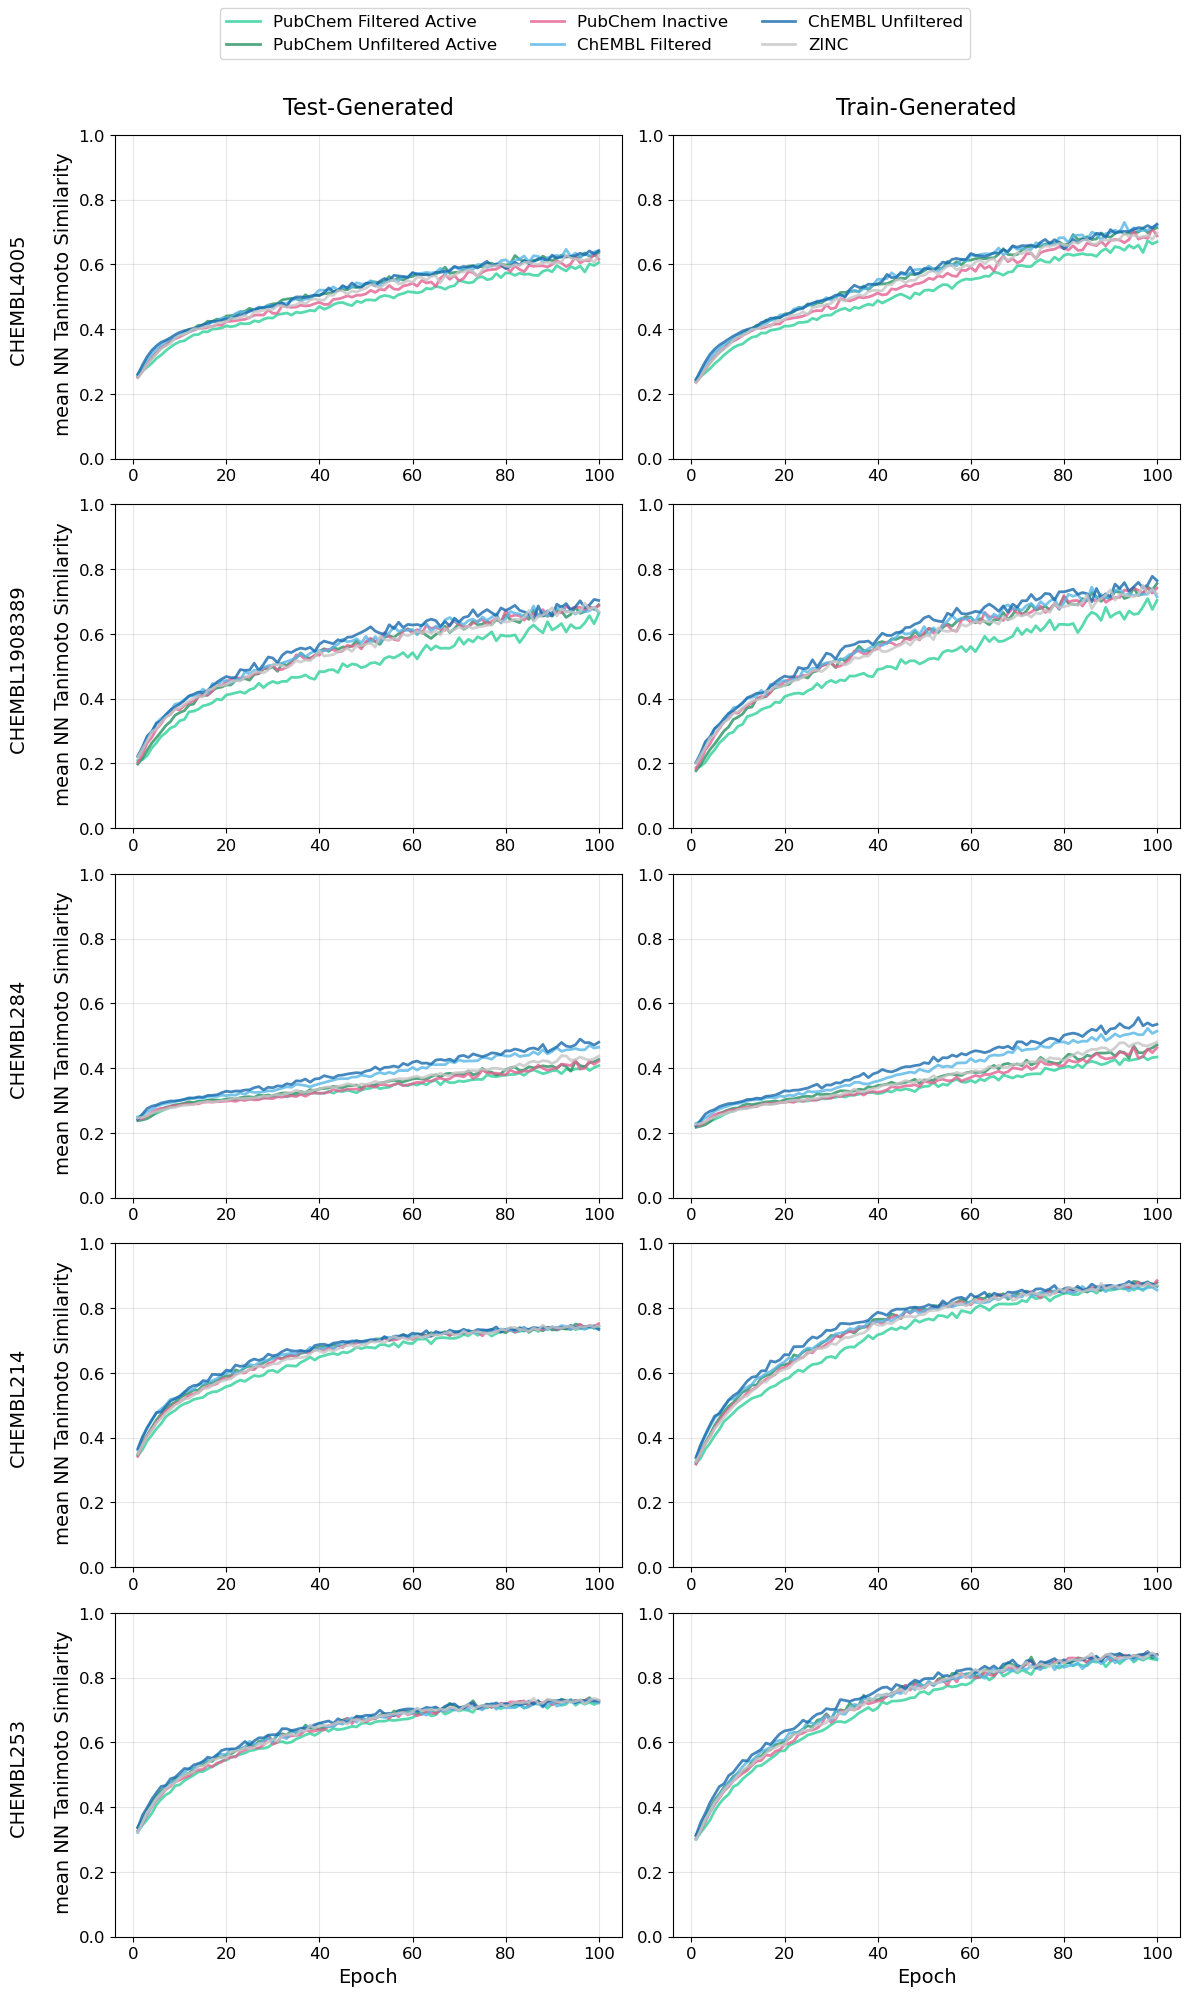

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

pretrain_labels = ['PubChem Filtered Active', 'PubChem Unfiltered Active', 'PubChem Inactive', 'ChEMBL Filtered', 'ChEMBL Unfiltered', 'ZINC']
dataset_colors  = ["#2ED19A", "#279260", "#E36191", "#58B6E6", "#186BAE", "#C6C5C5"]
epochs = list(range(1,101))
width  = 2

test_gen_dfs  = {}
train_gen_dfs = {}

for f_data in f_data_list:
    test_gen_dfs[f_data]  = pd.read_table(f'{FINETUNE_OUT}/mean_nn_Tanimoto_Simi/{FINETUNE_FILTER}_finetune_{f_data}_test_gen_mean_nn_Tanimoto_Simi_transition.tsv', index_col=0)
    train_gen_dfs[f_data] = pd.read_table(f'{FINETUNE_OUT}/mean_nn_Tanimoto_Simi/{FINETUNE_FILTER}_finetune_{f_data}_train_gen_mean_nn_Tanimoto_Simi_transition.tsv', index_col=0)

fig, axs = plt.subplots(5, 2, figsize=(12, 20))

for row, f_data in enumerate(f_data_list):
    for col, (data_dict, title) in enumerate([(test_gen_dfs, 'Test-Generated'),
                                              (train_gen_dfs, 'Train-Generated')]):
        ax = axs[row, col]
        for idx, dataset in enumerate(dataset_list):
            data = data_dict[f_data].loc[dataset, :]
            ax.plot(epochs, data, label=pretrain_labels[idx], color=dataset_colors[idx], alpha=0.8, linewidth=width)

        ax.set_ylim(0,1)
        ax.tick_params(labelsize=12)
        ax.grid(True, alpha=0.3)

        if row == 0:
            ax.set_title(title, fontsize=16, pad=15)
        if row == 4:
            ax.set_xlabel('Epoch', fontsize=14)
        if col == 0:
            ax.set_ylabel(f'{f_data} \n \n mean NN Tanimoto Similarity', fontsize=14)

handles, labels = axs[0, 0].get_legend_handles_labels()

for handle in handles:
    handle.set_linewidth(width)

fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig(f'{FIGURES_DIR}/finetune/{FINETUNE_FILTER}/mean_NN_Tanimoto_Similarity_all.png', dpi=300)

#### Aggregate Generated SMILES from 100 Epochs

In [2]:
import os
import pandas as pd
from src.chem_utils import read_smiles_list_tsv, is_valid_smiles

epochs = list(range(1,101))

for f_data in f_data_list:
    print(f'=== {f_data} ===')
    save_dir = f'{FINETUNE_RESULTS}/all_unique_smiles/{f_data}/'
    os.makedirs(save_dir, exist_ok=True)

    for dataset in dataset_list:
        all_smi = []
        for epoch in epochs:
            gen_path      = f'{FINETUNE_RESULTS}/{dataset}_results/{f_data}_finetune/sampling/epoch{epoch}_10000samples.tsv'
            gen_smi_list  = read_smiles_list_tsv(gen_path, col='canonical_smiles', dropna=True, dedup=True)
            all_smi.extend(gen_smi_list)
        
        all_smi   = list(set(all_smi))
        valid_smi = [s for s in all_smi if is_valid_smiles(s)]

        all_val_smi_df = pd.DataFrame(valid_smi, columns=['canonical_smiles'])
        all_val_smi_df.to_csv(f'{save_dir}/{f_data}_{dataset}_all_uniq_smiles.tsv', sep='\t')

=== CHEMBL4005 ===


[17:45:53] Can't kekulize mol.  Unkekulized atoms: 2 3 6
[17:46:13] Can't kekulize mol.  Unkekulized atoms: 3 4 26
[17:46:18] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 21 22 23 31 32 33


=== CHEMBL1908389 ===
=== CHEMBL284 ===
=== CHEMBL214 ===
=== CHEMBL253 ===


## 2. Post-Generation Filtering

### 2-1. Filter-pass-rate per Epoch

In [ ]:
import os
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem.FilterCatalog import FilterCatalogParams, FilterCatalog
from joblib import Parallel, delayed, cpu_count
from src.chem_utils import read_smiles_list_tsv, smiles_to_mols
from src.dataset_curation import filter_structural_alerts
from tqdm import tqdm
RDLogger.DisableLog('rdApp.*')

epochs = list(range(1,101))

for f_data in f_data_list:
    for dataset in dataset_list:
        save_dir = f'{FINETUNE_OUT}/filtering/{f_data}/{dataset}_filterdata/'
        os.makedirs(save_dir, exist_ok=True)
        stats = []

        for epoch in tqdm(epochs, desc=f'{dataset} Epochs'):
            gen_smi_df = pd.read_table(f'{FINETUNE_RESULTS}/{dataset}_results/{f_data}_finetune/sampling/epoch{epoch}_10000samples.tsv', index_col=0)
            gen_smi_df = gen_smi_df.dropna(subset=['canonical_smiles']).drop_duplicates(subset=['canonical_smiles'])

            passed_df, pass_rate, filter_flags = filter_structural_alerts(gen_smi_df, 'canonical_smiles')

            filter_flags.to_csv(f'{save_dir}/{dataset}_epoch{epoch}_flags.tsv', sep='\t')
            passed_df.to_csv(f'{save_dir}/{dataset}_epoch{epoch}_all_passed_smiles.tsv', sep='\t')

            n_valid   = filter_flags.shape[0]
            n_passed  = len(passed_df)
            stats.append({'epoch': epoch, '#valid': n_valid, '#passed': n_passed, 'pass_rate': pass_rate})

        stats_df = pd.DataFrame(stats).set_index('epoch')
        stats_df.to_csv(f'{FINETUNE_OUT}/filtering/{f_data}/{dataset}_filter_pass_rate.tsv', sep='\t')

**Visualize**

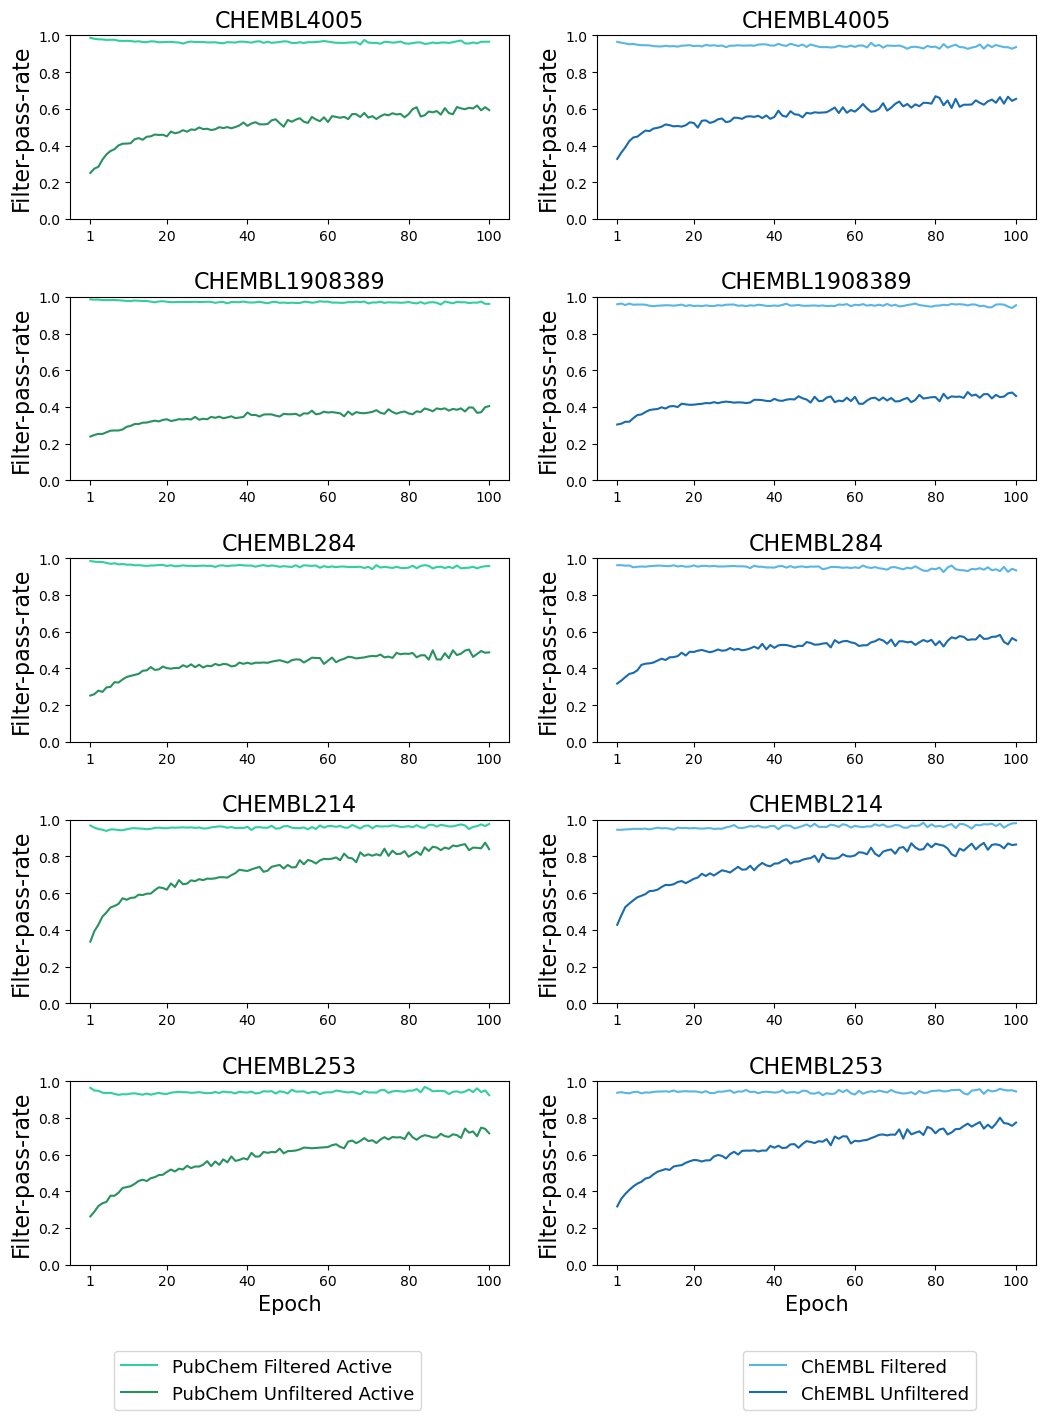

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from src.dataset_curation import filter_structural_alerts

DOMAINS = [
    ('pubchem', ['pubchem_filtered_ac', 'pubchem_unfiltered_ac']),
    ('chembl',  ['chembl_filtered', 'chembl_unfiltered'])
]
LABELS = {
    'pubchem': ['PubChem Filtered Active', 'PubChem Unfiltered Active', 'Target data'],
    'chembl':  ['ChEMBL Filtered', 'ChEMBL Unfiltered', 'Target data']
}
COLORS = {
    'pubchem': ['#2ED19A', '#279260'],
    'chembl':  ['#58B6E6', '#186BAE']
}

rows, cols = len(f_data_list), 2
fig, axs = plt.subplots(rows, cols, figsize=(11, 3 * rows), squeeze=False)
font_size = 16
legend_handles = {'pubchem': None, 'chembl': None}

for row, f_data in enumerate(f_data_list):
    target_pass_rate = None
    if FINETUNE_FILTER == 'unfiltered':
        train_smi = pd.read_table(f'{FINETUNE_DATA}/unfiltered-{f_data}_train.tsv')
        _, target_pass_rate, _ = filter_structural_alerts(train_smi, 'rdkit_smiles')

    for col, (domain, datasets) in enumerate(DOMAINS):
        ax = axs[row, col]
        ax.set_title(f_data, fontsize=font_size)

        filt_name, unfilt_name = datasets
        fp = pd.read_table(f'{FINETUNE_OUT}/filtering/{f_data}/{filt_name}_filter_pass_rate.tsv', index_col=0)
        up = pd.read_table(f'{FINETUNE_OUT}/filtering/{f_data}/{unfilt_name}_filter_pass_rate.tsv', index_col=0)

        epochs = range(1, 101)
        y1 = fp['pass_rate'].values[:100]
        y2 = up['pass_rate'].values[:100]

        l1, = ax.plot(epochs, y1, label=LABELS[domain][0], color=COLORS[domain][0])
        l2, = ax.plot(epochs, y2, label=LABELS[domain][1], color=COLORS[domain][1])

        l3 = None
        if target_pass_rate is not None:
            l3 = ax.axhline(y=target_pass_rate, color='gray', alpha=0.7, linestyle='--',
                            label=LABELS[domain][2])

        if legend_handles[domain] is None:
            legend_handles[domain] = (l1, l2, l3) if l3 is not None else (l1, l2)

        ax.set_ylim(0, 1)
        ax.set_xticks([1, 20, 40, 60, 80, 100])
        if row == rows - 1:
            ax.set_xlabel('Epoch', fontsize=15)
        ax.set_ylabel('Filter-pass-rate', fontsize=font_size)

if FINETUNE_FILTER == 'unfiltered':
    if legend_handles['pubchem'] is not None:
        fig.legend(handles=legend_handles['pubchem'],
                   labels=LABELS['pubchem'],
                   loc='lower left', bbox_to_anchor=(0.12, 0.02), fontsize=13)
    if legend_handles['chembl'] is not None:
        fig.legend(handles=legend_handles['chembl'],
                   labels=LABELS['chembl'],
                   loc='lower right', bbox_to_anchor=(0.92, 0.02), fontsize=13)
else:
    if legend_handles['pubchem'] is not None:
        fig.legend(handles=legend_handles['pubchem'][:2],
                   labels=LABELS['pubchem'][:2],
                   loc='lower left', bbox_to_anchor=(0.12, 0.02), fontsize=13)
    if legend_handles['chembl'] is not None:
        fig.legend(handles=legend_handles['chembl'][:2],
                   labels=LABELS['chembl'][:2],
                   loc='lower right', bbox_to_anchor=(0.92, 0.02), fontsize=13)

plt.tight_layout(rect=[0.02, 0.08, 0.98, 0.97], h_pad=2, w_pad=2)
plt.savefig(f'{FIGURES_DIR}/finetune/{FINETUNE_FILTER}/finetune_filter-pass-rate.png', dpi=300)


### 2-2. Overall filter-pass-rate (all 100 epochs)


In [6]:
import os
import pandas as pd

epochs  = list(range(1, 101))
overall = {}
for f_data in f_data_list:
    save_dir = f'{FINETUNE_OUT}/filtering/{f_data}/all_epochs_passed_smiles/'
    os.makedirs(save_dir, exist_ok=True)
    
    row = {}
    for dataset in dataset_list:
        valid_smi  = set()
        all_passed = set()

        for epoch in epochs:
            smi      = read_smiles_list_tsv(f'{FINETUNE_OUT}/filtering/{f_data}/{dataset}_filterdata/{dataset}_epoch{epoch}_flags.tsv')
            valid_smi.update(smi)
            smi_pass = read_smiles_list_tsv(f'{FINETUNE_OUT}/filtering/{f_data}/{dataset}_filterdata/{dataset}_epoch{epoch}_all_passed_smiles.tsv')
            all_passed.update(smi_pass)

        all_passed_smi_df = pd.DataFrame(all_passed, columns=['canonical_smiles'])
        all_passed_smi_df.to_csv(f'{save_dir}/{dataset}_all_epochs_passed_smiles.tsv', sep='\t')

        row[dataset] = (len(all_passed) / len(valid_smi))

    overall[f_data] = row
overall_df = pd.DataFrame.from_dict(overall, orient='index').reindex(columns=dataset_list).round(3)
overall_df.to_csv(f'{FINETUNE_OUT}/filtering/overall_filter_pass_rate.tsv', sep='\t')
overall_df

,pubchem_filtered_ac,pubchem_unfiltered_ac,pubchem_inac,chembl_filtered,chembl_unfiltered,zinc
CHEMBL4005,0.944,0.416,0.508,0.931,0.476,0.613
CHEMBL1908389,0.944,0.321,0.419,0.935,0.396,0.570
CHEMBL284,0.928,0.356,0.438,0.938,0.441,0.574
CHEMBL214,0.927,0.527,0.581,0.935,0.570,0.675
CHEMBL253,0.904,0.424,0.491,0.921,0.475,0.581


### 2-3. Diversity Comparison: Tanimoto Similarity Distributions (Filtered / Unfiltered Pretraining)


=== CHEMBL4005 ===
=== CHEMBL1908389 ===
=== CHEMBL284 ===
=== CHEMBL214 ===
=== CHEMBL253 ===


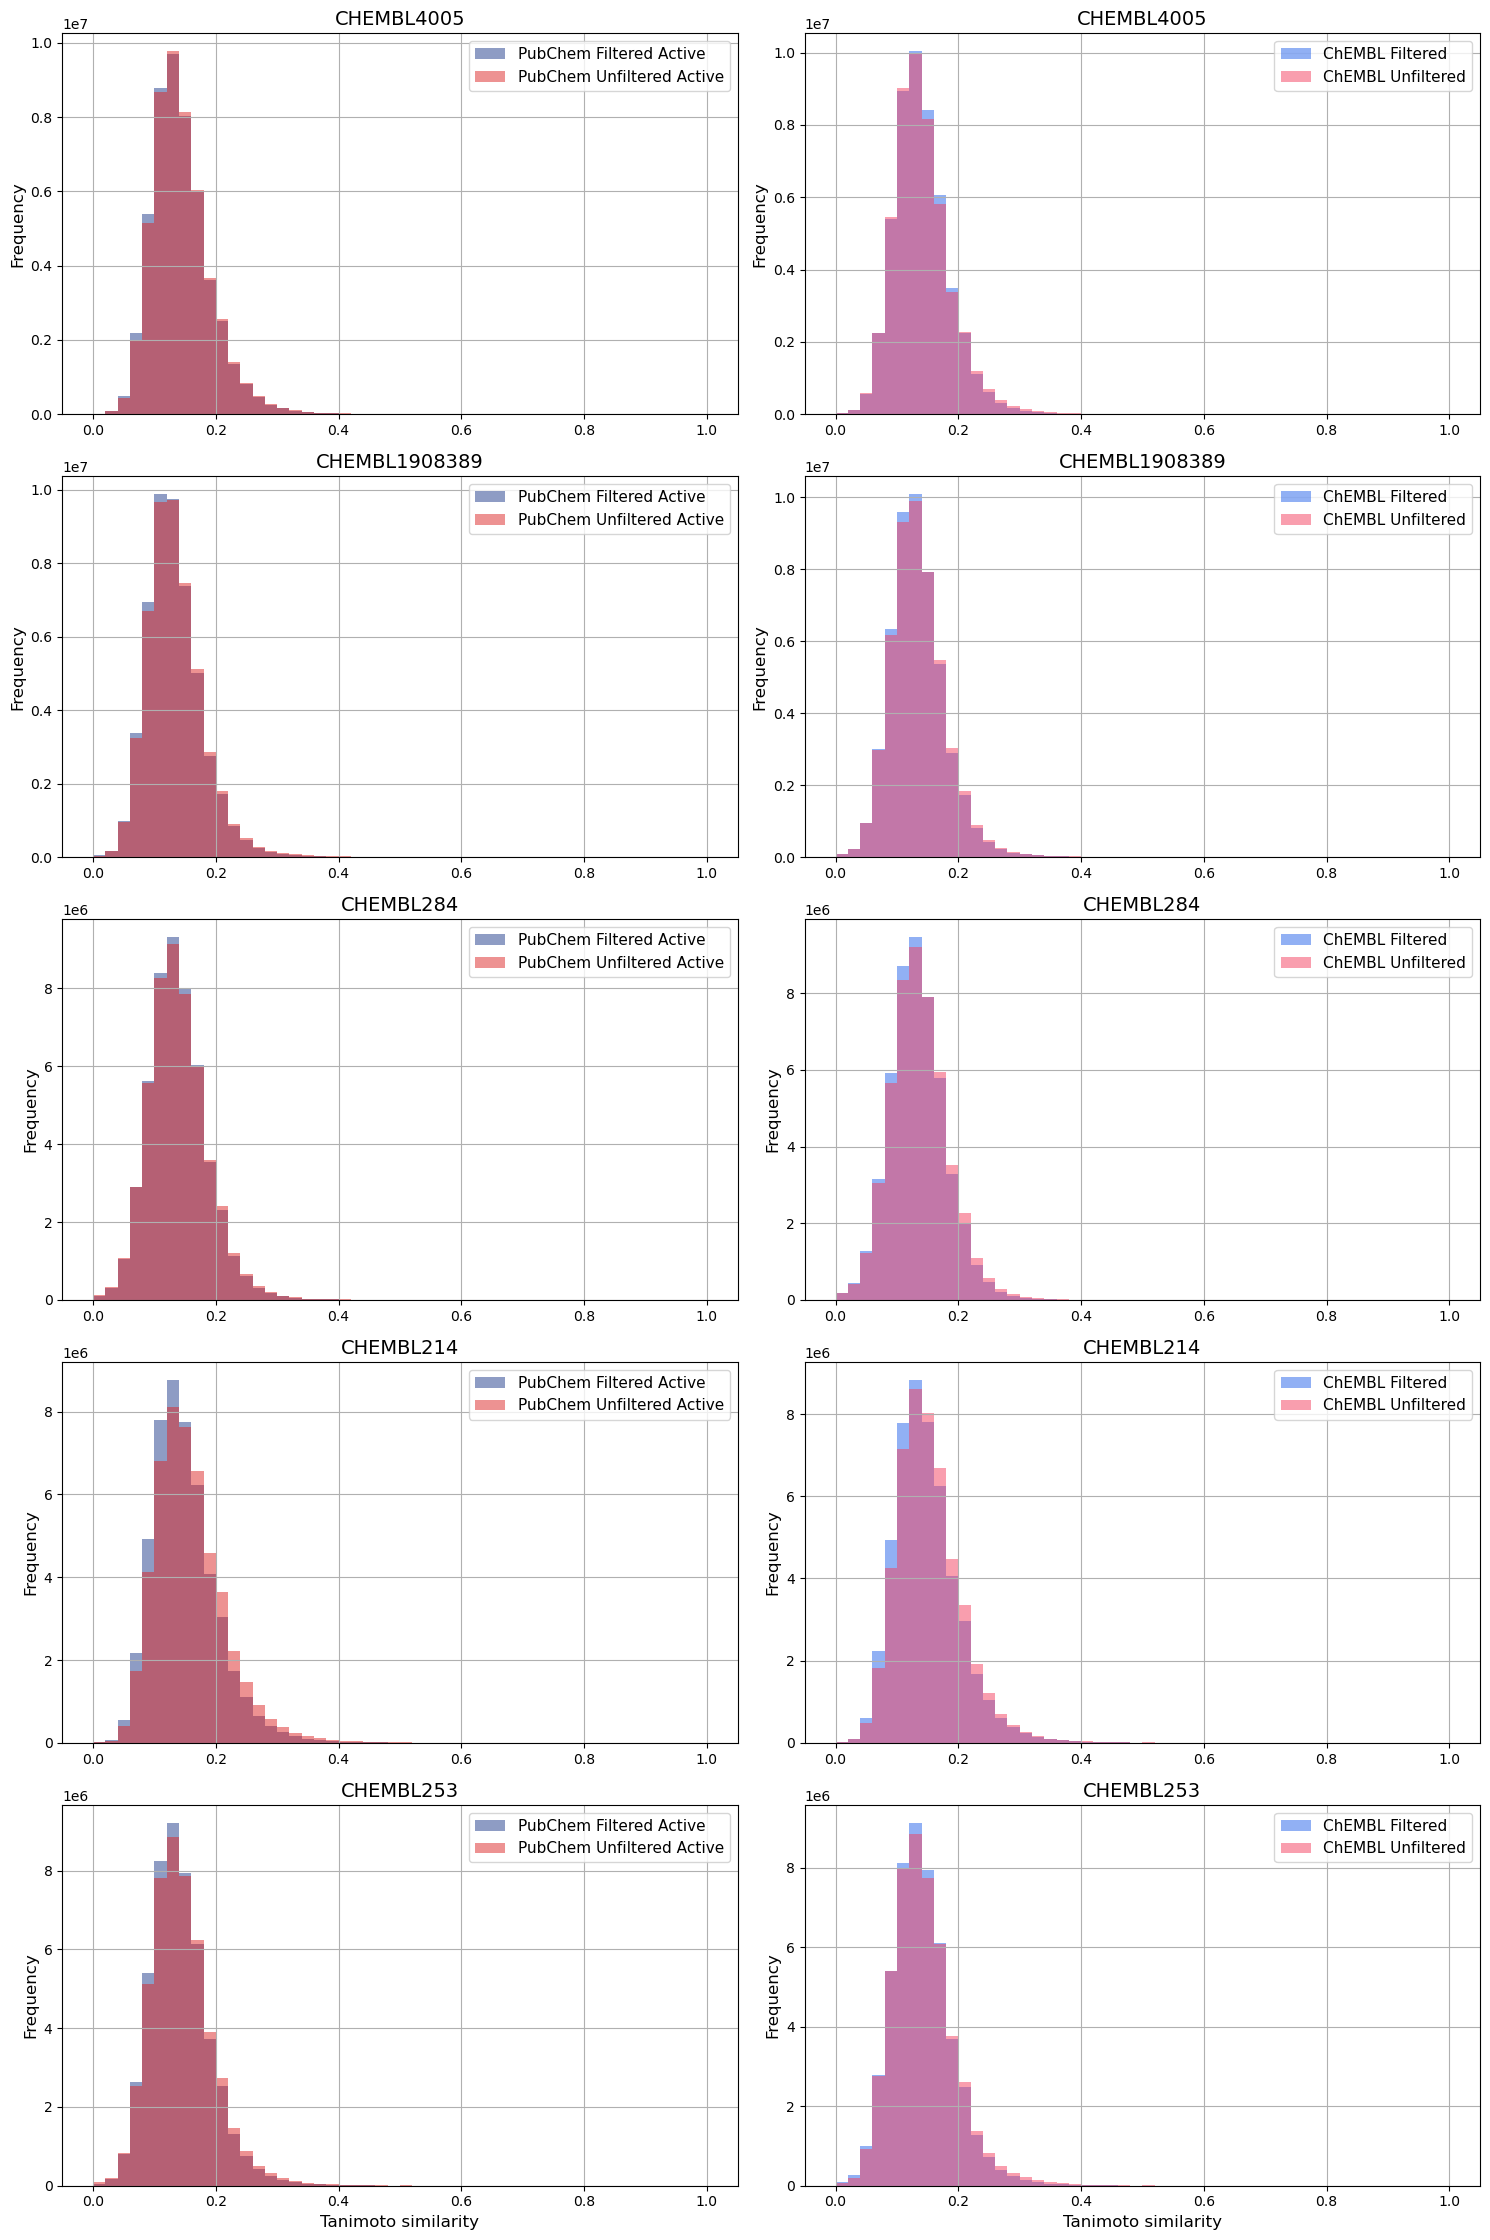

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from tqdm import tqdm
from src.chem_utils import read_smiles_list_tsv, generate_self_tanimoto_matrix

DOMAINS = [
    ('pubchem', ['pubchem_filtered_ac', 'pubchem_unfiltered_ac']),
    ('chembl',  ['chembl_filtered',    'chembl_unfiltered'])
]
LABELS = {
    'pubchem': ['PubChem Filtered Active', 'PubChem Unfiltered Active'],
    'chembl' : ['ChEMBL Filtered', 'ChEMBL Unfiltered']
}
COLORS = {
    'pubchem': ['#1E3A8A', '#DC2626'],
    'chembl':  ['#2563EB', '#F43F5E']
}

rows, cols = len(f_data_list), 2
fig, axs = plt.subplots(rows, cols, figsize=(15, 4.5 * rows), squeeze=False)

SAMPLE_SIZE = 10000
save_dir = f'{FINETUNE_OUT}/tanimoto_sim_distribution/'
os.makedirs(save_dir, exist_ok=True)

for row, f_data in enumerate(f_data_list):
    print(f'=== {f_data} ===')
    for col, (domain, datasets) in enumerate(DOMAINS):
        ax = axs[row, col]
        ax.set_title(f'{f_data}', fontsize=14)
        if row == len(f_data_list) - 1:
            ax.set_xlabel('Tanimoto similarity', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.grid(True)

        for ds_idx, dataset in enumerate(datasets):
            pass_smi_path = f'{FINETUNE_OUT}/filtering/{f_data}/all_epochs_passed_smiles/{dataset}_all_epochs_passed_smiles.tsv'
            smiles_list = read_smiles_list_tsv(pass_smi_path, col='canonical_smiles', dropna=True, dedup=True)

            n_sample = min(SAMPLE_SIZE, len(smiles_list))
            sampled = pd.Series(smiles_list).sample(n=n_sample, random_state=42).tolist()

            tani = generate_self_tanimoto_matrix(sampled)

            m = tani.values
            iu = np.triu_indices(m.shape[0], k=1)
            vals = m[iu]

            label = LABELS[domain][ds_idx]
            color = COLORS[domain][ds_idx]
            ax.hist(vals, bins=50, alpha=0.5, label=label, color=color)

            out_path = f'{save_dir}{f_data}_{dataset}_tanimoto_sim_matrix.tsv'
            tani.to_csv(out_path, sep='\t', index=False)

            del tani, m, vals

        ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/finetune/{FINETUNE_FILTER}/tanimoto_sim_distribution.png', dpi=300)


## 3. Rediscovery
Rediscovery quantifies the ability of the model to regenerate known bioactive compounds that are excluded during training.
  
Rediscovery is defined as follows:
  
$$\text{Rediscovery} = \frac{\text{Number of test SMILES found in generated SMILES}}{\text{Number of test SMILES}}$$


### 3-1 Epoch-wise Rediscovery

In [ ]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from src.metrics import calc_rediscovery
from src.chem_utils import read_smiles_list_tsv


def load_and_calculate_rediscovery(datapath, test_smi):
    redisc_dict = {}
    for epoch in range(1, 101):
        path = datapath
        gen_smi = read_smiles_list_tsv(f'{path}/sampling/epoch{epoch}_10000samples.tsv', 
                                                 col='canonical_smiles', dropna=True, dedup=True)
        redisc_dict[f'epoch{epoch}'] = calc_rediscovery(gen_smi, test_smi)
    return redisc_dict

def plot_rediscovery(ax, redisc_df, dataset, colors, f_data, is_last):
    for folder, color in zip(dataset, colors):
        ax.plot(range(1, 101), redisc_df[folder], color=color, alpha=0.95)
        ax.set_xticks([1, 20, 40, 60, 80, 100])
    
    ax.set_title(f_data, fontsize=13)
    ax.set_ylabel('Rediscovery', fontsize=13)
    if is_last:
        ax.set_xlabel('Epoch', fontsize=13)

epochs = list(range(1, 101))

for f_data in f_data_list:
    test_smi    = read_smiles_list_tsv(f'{FINETUNE_DATA}/{FINETUNE_FILTER}-{f_data}_test.tsv', col='rdkit_smiles')
   
    all_redisc_dict = {}
    for dataset in dataset_list:
        gen_path = f'{FINETUNE_RESULTS}/{dataset}_results/{f_data}_finetune/'
        all_redisc_dict[dataset] = load_and_calculate_rediscovery(gen_path, test_smi)

    redisc_df = pd.DataFrame(all_redisc_dict)
    save_dir = f'{FINETUNE_OUT}/rediscovery/'
    os.makedirs(save_dir, exist_ok=True)
    redisc_df.to_csv(f'{save_dir}/{f_data}_all_rediscovery.tsv', sep='\t')


**Visualize**

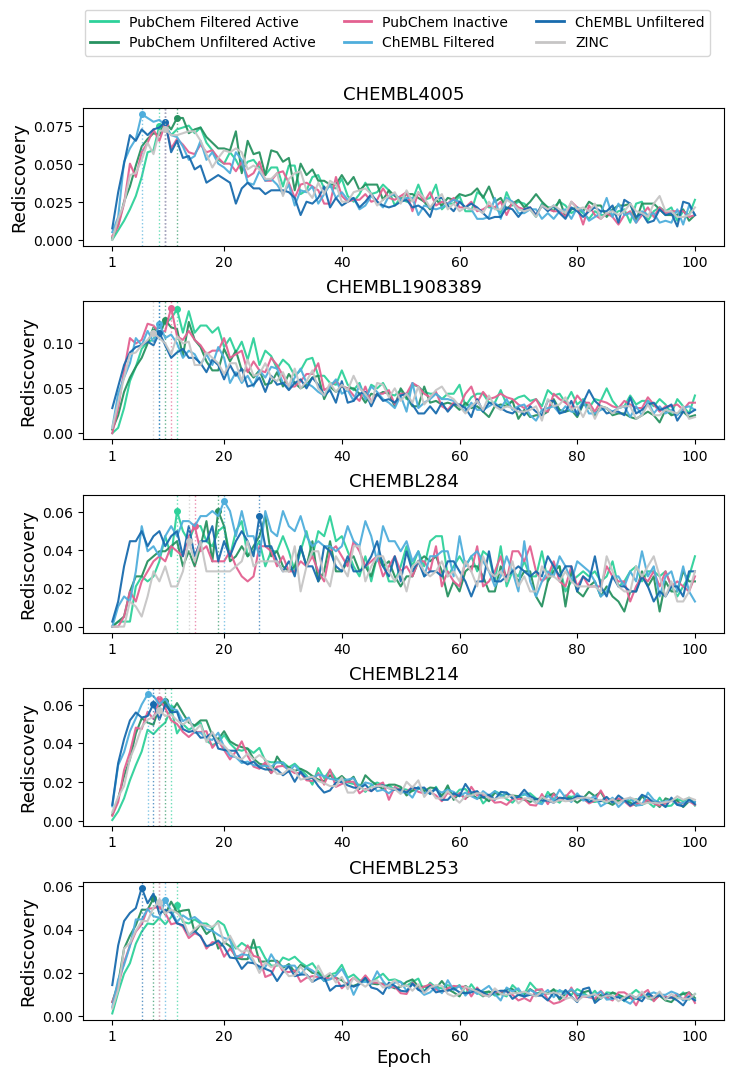

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def plot_rediscovery_with_peaks(ax, redisc_df, dataset_list, colors, f_data, is_last):
    for dataset, color in zip(dataset_list, colors):
        values = redisc_df[dataset].values
        epochs = range(1, 101)
        
        # Plot main line
        ax.plot(epochs, values, color=color, alpha=0.95)
        
        max_idx = np.argmax(values)
        max_epoch = max_idx + 1
        max_value = values[max_idx]
        
        ax.axvline(x=max_epoch, color=color, linestyle=':', alpha=0.7, linewidth=1)
        ax.plot(max_epoch, max_value, 'o', color=color, markersize=4)
        
    ax.set_xticks([1, 20, 40, 60, 80, 100])
    ax.set_title(f_data, fontsize=13)
    ax.set_ylabel('Rediscovery', fontsize=13)
    if is_last:
        ax.set_xlabel('Epoch', fontsize=13)

dataset_names = ['PubChem Filtered Active', 'PubChem Unfiltered Active', 'PubChem Inactive', 'ChEMBL Filtered', 'ChEMBL Unfiltered', 'ZINC']
dataset_colors = ["#2ED19A", "#279260", "#E36191", '#4FAEDC', "#186BAE", "#C6C5C5"]

fig, axs = plt.subplots(len(f_data_list), 1, figsize=(8.27, 11.69))

legend_handles = [Line2D([0], [0], color=color, linewidth=2, label=name) 
                for color, name in zip(dataset_colors, dataset_names)]

for i, (ax, f_data) in enumerate(zip(axs, f_data_list)):
    redisc_df = pd.read_table(f'{save_dir}/{f_data}_all_rediscovery.tsv', index_col=0)
    plot_rediscovery_with_peaks(ax, redisc_df, dataset_list, dataset_colors, f_data, i == len(f_data_list) - 1)

# Place legend properly
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.505, 0.98), fontsize=10)
fig.subplots_adjust(hspace=0.4, top=0.89)

fig_dir = f'{FIGURES_DIR}/finetune/{FINETUNE_FILTER}/'
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(f'{fig_dir}/rediscovery_plot_with_peaks.png', dpi=400, bbox_inches='tight')

### 3-2. Overall Rediscovery (all 100 epochs)

In [ ]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from src.metrics import calc_rediscovery
from src.chem_utils import read_smiles_list_tsv

rows = []

for f_data in f_data_list:
    test_smi    = read_smiles_list_tsv(f'{FINETUNE_DATA}/{FINETUNE_FILTER}-{f_data}_test.tsv', col='rdkit_smiles')
    
    redisc_dict = {}
    for dataset in dataset_list:
        all_epo_smi = read_smiles_list_tsv(f'{FINETUNE_RESULTS}/all_unique_smiles/{f_data}/{f_data}_{dataset}_all_uniq_smiles.tsv', col='canonical_smiles')
        redisc      = calc_rediscovery(all_epo_smi, test_smi)
        redisc_dict[dataset] = redisc
    
    rows.append({'finetune_data': f_data, **redisc_dict})

all_redisc_df = pd.DataFrame(rows).set_index('finetune_data').round(3)

save_dir = f'{FINETUNE_OUT}/rediscovery/'
os.makedirs(save_dir, exist_ok=True)
all_redisc_df.to_csv(f'{save_dir}/overall_rediscovery.tsv', sep='\t')
all_redisc_df


,pubchem_filtered_ac,pubchem_unfiltered_ac,pubchem_inac,chembl_filtered,chembl_unfiltered,zinc
finetune_data,,,,,,
CHEMBL4005,0.252,0.259,0.248,0.264,0.273,0.254
CHEMBL1908389,0.340,0.330,0.352,0.340,0.344,0.334
CHEMBL284,0.182,0.189,0.205,0.224,0.221,0.174
CHEMBL214,0.247,0.256,0.248,0.247,0.263,0.239
CHEMBL253,0.205,0.224,0.212,0.213,0.236,0.219


## 4. FastTargetPred
FastTargetPred is a ligand-based target prediction tool that inders potential protein targets for a given compound.
  
doi:[10.1093/bioinformatics/btaa494](https://academic.oup.com/bioinformatics/article/36/14/4225/5836501)

### 4-1. Setup
- Clone the [FastTargetPred](https://github.com/ludovicchaput/FastTargetPred) repository and place it into the `tools` directory:

In [ ]:
!git clone https://github.com/ludovicchaput/FastTargetPred.git ../tools/FastTargetPred-master

Cloning into '../tools/FastTargetPred-master'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (31/31), done.
remote: Total 247 (delta 30), reused 30 (delta 30), pack-reused 216 (from 1)
Receiving objects: 100% (247/247), 96.06 MiB | 21.75 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Updating files: 100% (47/47), done.


- Download [MayaChemTools](https://www.mayachemtools.org/Download.html) and place it into the `tools` directory.

In [40]:
# Add MayaChemTools 'bin' directory to the PATH (required for FastTargetPred)
import os
os.environ["PATH"] += '../tools/mayachemtools/bin'

- make SDF file all generated SMILES.

In [ ]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

for f_data in tqdm(f_data_list):
    sdf_path = f'../tools/FastTargetPred-master/gen_smiles/{f_data}/'
    os.makedirs(sdf_path, exist_ok=True)

    for dataset in dataset_list:
        all_smi_df = pd.read_table(f'{FINETUNE_RESULTS}/all_unique_smiles/{f_data}/{f_data}_{dataset}_all_uniq_smiles.tsv', index_col=0)

        mols  = []
        invalid_rows = []
        for idx, smi in all_smi_df['canonical_smiles'].items():
            mol = Chem.MolFromSmiles(smi)
            if mol is None: 
                invalid_rows.append((idx, smi))
                continue

            AllChem.Compute2DCoords(mol)

            mol.SetProp('_Name', str(idx))
            mol.SetProp('SMILES', str(smi))
            mols.append(mol)

        writer = Chem.SDWriter(f'{sdf_path}{dataset}_finetune_gensmiles.sdf')
        for m in mols:
            writer.write(m)
        writer.close()
        if invalid_rows:
            print(f'[Warning] {dataset}/{f_data}: invalid SMILES ({len(invalid_rows)})')


  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [03:49<15:19, 229.83s/it][23:39:33] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[23:39:33] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
100%|██████████| 5/5 [19:14<00:00, 230.89s/it]


In [ ]:
# Pre-training datasets
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
from src.paths import PRETRAIN_DATA


sdf_path = f'../tools/FastTargetPred-master_2/pretrain_smiles/'
os.makedirs(sdf_path, exist_ok=True)

for dataset in dataset_list:
    all_smi_df = pd.read_table(f'{PRETRAIN_DATA}/sampled_datasets/{dataset}.tsv', index_col=0)

    mols  = []
    invalid_rows = []
    for idx, smi in all_smi_df['rdkit_smiles'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None: 
            invalid_rows.append((idx, smi))
            continue

        
        AllChem.Compute2DCoords(mol)

        mol.SetProp('_Name', str(idx))
        mol.SetProp('SMILES', str(smi))
        mols.append(mol)

    writer = Chem.SDWriter(f'{sdf_path}{dataset}.sdf')
    for m in mols:
        writer.write(m)
    writer.close()
    if invalid_rows:
        print(f'[Warning] {dataset}/{f_data}: invalid SMILES ({len(invalid_rows)})')


### 4-2. Run FastTargetPred


In [ ]:
!mkdir -p ../FastTargetPred-master/output

Don't forget to set `-nbt 0`, otherwise it will predict at most 99 targets.

> This step takes a long time.

In [ ]:
!python FastTargetPred.py gen_smiles/CHEMBL4005/pubchem_filtered_ac_finetune_gensmiles.sdf -o output/CHEMBL4005_pubchem_filtered_ac_FTP.tsv -f csv -nbt 0 -cpu 12

Change the pre-training and fine-tuning dataset names, and run the same command for the others.

### 4-3. Average Number of Targets

In [ ]:
f_data_list = ['CHEMBL4005']

In [ ]:
import pandas as pd


table = {}
for f_data in f_data_list:
    row = {}
    for dataset in dataset_list:
        pred_target_df = pd.read_csv(f'../tools/FastTargetPred-master/output/{f_data}_{dataset}_FTP.tsv', sep='\t')
        nan_droped_df  = pred_target_df.dropna(subset=['target_id'])
        counts = nan_droped_df['query_name'].value_counts()
       
        uniq_query_df  = nan_droped_df.drop_duplicates(subset=['query_name'])
        
        all_gen_smi     = pd.read_table(f'{FINETUNE_RESULTS}/all_unique_smiles/{f_data}/{f_data}_{dataset}_all_uniq_smiles.tsv', index_col=0)
        zero_target_num = len(all_gen_smi) - len(uniq_query_df)
        zero_series     = pd.Series([0]*zero_target_num)
        target_num_seri = pd.concat([counts, zero_series])
        avg             = target_num_seri.mean()
        row[dataset]    = avg

    table[f_data] = row

avg_target_num = pd.DataFrame.from_dict(table, orient='index').reindex(columns=dataset_list).round(3)
avg_target_num

,pubchem_filtered_ac,pubchem_unfiltered_ac,pubchem_inac,chembl_filtered,chembl_unfiltered,zinc
CHEMBL4005,0.262,0.218,0.109,0.292,0.306,0.062


Pre-training data

In [2]:
import pandas as pd
from src.paths import PRETRAIN_DATA

dataset_list = ['pubchem_filtered_ac', 'pubchem_unfiltered_ac', 'pubchem_inac', 'chembl_filtered', 'chembl_unfiltered', 'zinc']

table = {}
for dataset in dataset_list:
    pred_target_df = pd.read_csv(f'../tools/FastTargetPred-master_2/out/pretraindata_{dataset}_FTP.tsv', sep='\t')
    nan_droped_df  = pred_target_df.dropna(subset=['target_id'])
    counts = nan_droped_df['query_name'].value_counts()
    
    uniq_query_df  = nan_droped_df.drop_duplicates(subset=['query_name'])

    pretrain_smi     = pd.read_table(f'{PRETRAIN_DATA}/sampled_datasets/{dataset}.tsv', index_col=0)
    zero_target_num = len(pretrain_smi) - len(uniq_query_df)
    zero_series     = pd.Series([0]*zero_target_num)
    target_num_seri = pd.concat([counts.reset_index(drop=True), zero_series.reset_index(drop=True)])
    avg             = target_num_seri.mean()
    table[dataset]  = avg

avg_target_num = pd.DataFrame([table], index=['avg_targets']).round(3)
avg_target_num

,pubchem_filtered_ac,pubchem_unfiltered_ac,pubchem_inac,chembl_filtered,chembl_unfiltered,zinc
avg_targets,0.524,0.575,0.231,0.954,1.192,0.103


# 5. Visualize Structures

Visualize strucures from the models trained on Puchem_Filtered_Active and PubChem_Unfiltered_Active.

In [ ]:
import random
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from src.paths import FINETUNE_RESULTS, FINETUNE_OUT, FIGURES_DIR
from src.chem_utils import read_smiles_list_tsv

f_data = 'CHEMBL214'
pretrain_filt   = 'pubchem_filtered_ac'
pretrain_unfilt = 'pubchem_unfiltered_ac'

redisc_df = pd.read_table(f'{FINETUNE_OUT}/rediscovery/{f_data}_all_rediscovery.tsv', index_col=0)

epoch_filt = redisc_df[pretrain_filt].idxmax()
epoch_unfilt = redisc_df[pretrain_unfilt].idxmax()

filt_smi_path  = f'{FINETUNE_RESULTS}/{pretrain_filt}_results/{f_data}_finetune/sampling/{epoch_filt}_10000samples.tsv'
unfilt_smi_path= f'{FINETUNE_RESULTS}/{pretrain_unfilt}_results/{f_data}_finetune/sampling/{epoch_unfilt}_10000samples.tsv'
filt_smiles = read_smiles_list_tsv(filt_smi_path, dropna=True, dedup=True)
unfilt_smiles = read_smiles_list_tsv(unfilt_smi_path, dropna=True, dedup=True)

only_filt   = set(filt_smiles) - set(unfilt_smiles)
only_unfilt = set(unfilt_smiles) - set(filt_smiles)

random.seed(42)
samp_filt   = random.sample(list(only_filt), 30)
samp_unfilt = random.sample(list(only_unfilt), 30)

rdDepictor.SetPreferCoordGen(True)
for tag, smi_list, ep in [
    ("filtered", samp_filt, epoch_filt),
    ("unfiltered", samp_unfilt, epoch_unfilt)
]:
    mols = [Chem.MolFromSmiles(s) for s in smi_list if Chem.MolFromSmiles(s)]
    for m in mols:
        rdDepictor.Compute2DCoords(m)
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(400, 400))
    img.save(f'{FIGURES_DIR}/{f_data}_{tag}-only_{ep}.png')